In [1]:
import pandas as pd
import numpy as np
 
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import pymc3 as pm
print(pm.__version__)
import theano.tensor as tt
import patsy

C:\Miniconda3\envs\GLM_with_PyMC3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


3.3


# Reaction Times In A Sleep Deprivation Study
The dataset contains the average reaction time per day for subjects in a sleep deprivation study. On day 0 the subjects had their normal amount of sleep. Starting that night they were restricted to 3 hours of sleep per night. The observations represent the average reaction time on a series of tests given each day to each subject. Data from: https://raw.githubusercontent.com/vincentarelbundock/Rdatasets/master/csv/lme4/sleepstudy.csv

### Data loading

In [2]:
sleep = pd.read_csv('../datasets/sleepstudy.csv', index_col=0)
sleep['Subject'] = pd.Categorical(sleep['Subject'], ordered=False)
sleep.head(15)

,Reaction,Days,Subject
1,249.5600,0,308
2,258.7047,1,308
3,250.8006,2,308
4,321.4398,3,308
5,356.8519,4,308
6,414.6901,5,308
7,382.2038,6,308
8,290.1486,7,308
9,430.5853,8,308
10,466.3535,9,308


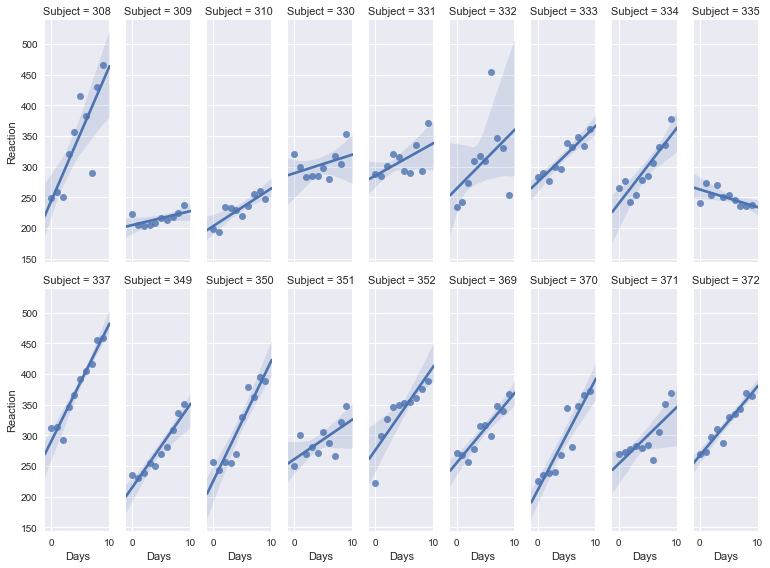

In [3]:
sns.lmplot(x="Days", y="Reaction", col="Subject", data=sleep, col_wrap=9, palette="muted", aspect=0.3, size=4)


## Random effect on the intercepts

In [4]:
X = patsy.dmatrix("1 + Days", data=sleep, return_type='dataframe')
X = np.asarray(X)
X[1:10, :]

array([[1., 1.],
       [1., 2.],
       [1., 3.],
       [1., 4.],
       [1., 5.],
       [1., 6.],
       [1., 7.],
       [1., 8.],
       [1., 9.]])

In [5]:
# Random effect on the intercepts
Z = patsy.dmatrix('0 + Subject', data=sleep, return_type='dataframe')
Z = np.asarray(Z)
Z

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [6]:
Y = np.asarray(sleep['Reaction'])
Y.mean()

298.50789166666664

In [7]:
with pm.Model() as model:

    #beta_X = pm.Normal('beta_X', mu=0, sd=100, shape=X.shape[1])
    
    beta_X_intercept = pm.Normal('beta_X_intercept', mu=Y.mean(), sd=100)
    beta_X_slope = pm.Normal('beta_X_slope', mu=0, sd=100)
    beta_X = pm.Deterministic('beta_X', tt.stack(beta_X_intercept, beta_X_slope))
    
    estimate_X = pm.math.dot(X, beta_X)

    sigma_Z = pm.HalfNormal('sigma_Z', sd=100)
      
    # Non Centered version
    gamma_Z_offset = pm.Normal('gamma_Z_offset', mu=0, sd=1, shape=Z.shape[1])
    gamma_Z = pm.Deterministic('gamma_Z', gamma_Z_offset * sigma_Z)
    
    estimate_Z = pm.math.dot(Z, gamma_Z)
    
    ## likelihood
    estimate = estimate_X + estimate_Z
    sigma = pm.HalfNormal('sigma', sd=100) # unexplained variability
    y_likelihood = pm.Normal('y_likelihood', mu=estimate, sd=sigma, observed=Y)
    
    trace = pm.sample(draws=5000, chains=4, njobs=2, tune=1500, nuts_kwargs={'target_accept':0.95})

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [sigma_log__, gamma_Z_offset, sigma_Z_log__, beta_X_slope, beta_X_intercept]
The number of effective samples is smaller than 25% for some parameters.


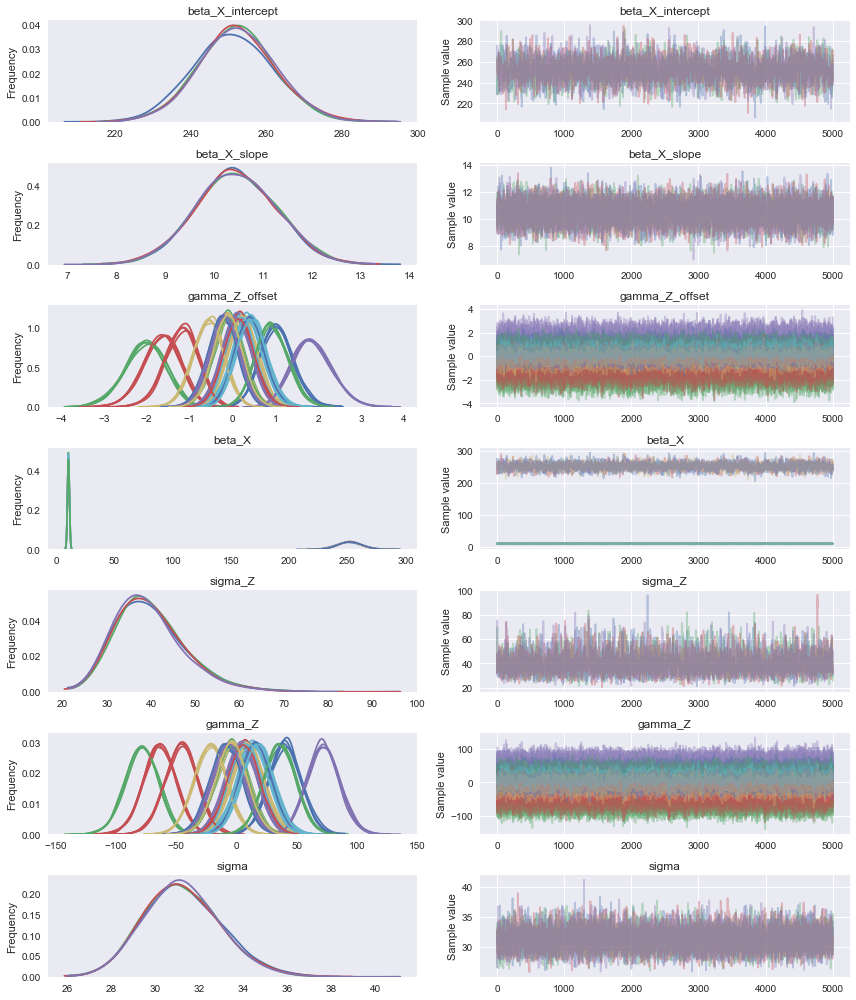

In [8]:
_ = pm.traceplot(trace)

In [9]:
pm.summary(trace)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
beta_X_intercept,252.054387,10.384074,0.202777,231.518443,272.361719,2411.628621,1.001417
beta_X_slope,10.451343,0.822596,0.008006,8.866241,12.077705,13041.819575,0.999936
gamma_Z_offset__0,1.043758,0.382330,0.006202,0.308850,1.812897,3924.919238,1.000643
gamma_Z_offset__1,-2.034732,0.473210,0.007492,-2.962006,-1.120658,4044.004187,1.001542
gamma_Z_offset__2,-1.650553,0.429714,0.006679,-2.516342,-0.833009,4209.712084,1.001100
gamma_Z_offset__3,0.099295,0.338779,0.005138,-0.557097,0.764782,4298.394983,1.000983
gamma_Z_offset__4,0.250709,0.340176,0.005207,-0.394487,0.934929,3835.262131,1.000925
gamma_Z_offset__5,0.200891,0.337957,0.005351,-0.477510,0.852928,4387.446297,1.000488
gamma_Z_offset__6,0.416473,0.347384,0.005154,-0.253945,1.110565,4110.977462,1.000692
gamma_Z_offset__7,-0.088868,0.338263,0.005164,-0.766044,0.568238,4096.872710,1.000914


array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001E91203BC18>,
      dtype=object)

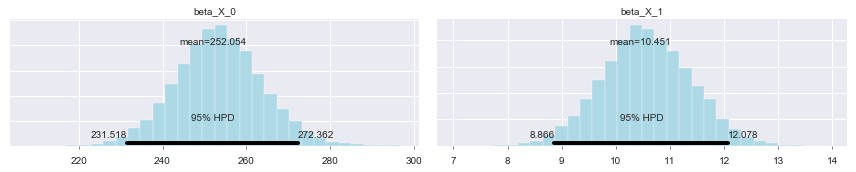

In [10]:
pm.plot_posterior(trace, varnames=['beta_X'], color='#add8e6')

## Random effect on the intercepts and slopes

In [45]:
X = patsy.dmatrix("1 + Days", data=sleep, return_type='dataframe')
X = np.asarray(X)
X[1:10, :]

array([[1., 1.],
       [1., 2.],
       [1., 3.],
       [1., 4.],
       [1., 5.],
       [1., 6.],
       [1., 7.],
       [1., 8.],
       [1., 9.]])

In [46]:
# Random effect on the intercepts and slopes
#Z = patsy.dmatrix('0 + Subject + Subject:Days', data=sleep, return_type='dataframe')
#Z = np.asarray(Z)
#np.all(np.equal(Z, np.concatenate((Z_intercepts, Z_slopes), axis=1)))

Z_intercept = patsy.dmatrix('0 + Subject', data=sleep, return_type='dataframe')
Z_intercept = np.asarray(Z_intercept)

Z_slope = patsy.dmatrix('0 + Subject:Days', data=sleep, return_type='dataframe')
Z_slope = np.asarray(Z_slope)

Z = np.concatenate((Z_intercept, Z_slope), axis=1)

In [47]:
Y = np.asarray(sleep['Reaction'])

In [55]:
with pm.Model() as model:

    #beta_X = pm.Normal('beta_X', mu=0, sd=100, shape=X.shape[1])
    
    # beta_X_intercept = pm.Normal('beta_X_intercept', mu=Y.mean(), sd=10000) # contrain it to positive values
    beta_X_intercept = pm.HalfNormal('beta_X_intercept', sd=100000) # contrain it to positive values
    beta_X_slope = pm.Normal('beta_X_slope', mu=0, sd=1000)
    beta_X = pm.Deterministic('beta_X', tt.stack(beta_X_intercept, beta_X_slope))
    
    estimate_X = pm.math.dot(X, beta_X)

    sigma_Z_intercept = pm.HalfNormal('sigma_Z_intercept', sd=1000)
    sigma_Z_slope = pm.HalfNormal('sigma_Z_slope', sd=1000)
      
    # Non Centered version
    #gamma_Z_offset = pm.Normal('gamma_Z_offset', mu=0, sd=1, shape=Z.shape[1])
    #gamma_Z = pm.Deterministic('gamma_Z', gamma_Z_offset * sigma_Z)
    #estimate_Z = pm.math.dot(Z, gamma_Z)
    
    gamma_Z_offset_intercept = pm.Normal('gamma_Z_offset_intercept', mu=0, sd=1000, shape=Z_intercept.shape[1])
    gamma_Z_intercept = pm.Deterministic('gamma_Z_intercept', gamma_Z_offset_intercept * sigma_Z_intercept)
    
    gamma_Z_offset_slope = pm.Normal('gamma_Z_offset_slope', mu=0, sd=1000, shape=Z_slope.shape[1])
    gamma_Z_slope = pm.Deterministic('gamma_Z_slope', gamma_Z_offset_slope * sigma_Z_slope)
    
    estimate_Z = pm.math.dot(Z_intercept, gamma_Z_intercept) + pm.math.dot(Z_slope, gamma_Z_slope) 
    
    ## likelihood
    estimate = estimate_X + estimate_Z
    sigma_unexplained = pm.HalfNormal('sigma', sd=1000) # unexplained variability
    y_likelihood = pm.Normal('y_likelihood', mu=estimate, sd=sigma_unexplained, observed=Y)
    
    trace = pm.sample(draws=5000, chains=4, njobs=2, tune=1500, nuts_kwargs={'target_accept':0.95})

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [sigma_log__, gamma_Z_offset_slope, gamma_Z_offset_intercept, sigma_Z_slope_log__, sigma_Z_intercept_log__, beta_X_slope, beta_X_intercept_log__]


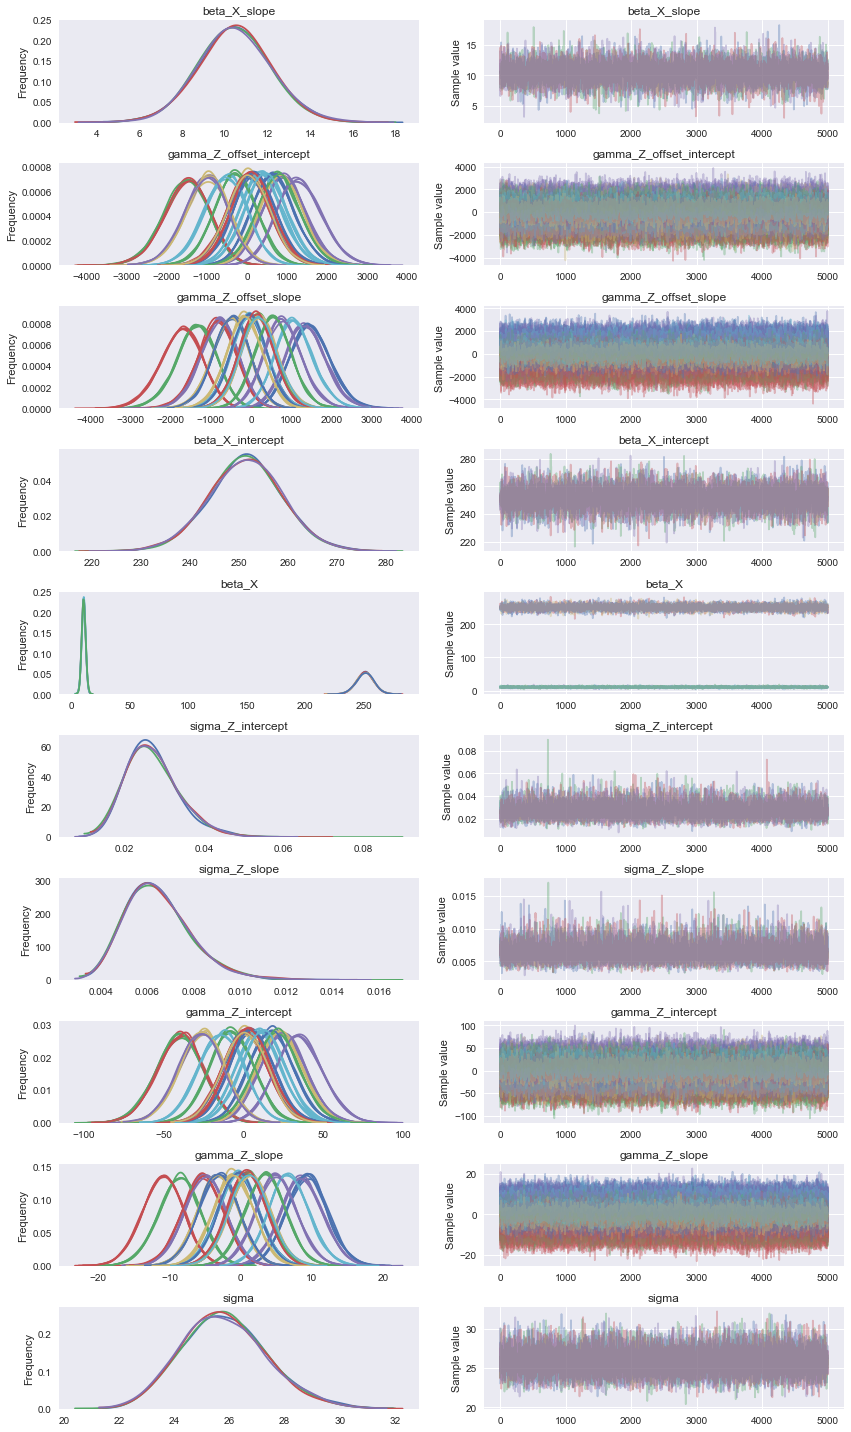

In [56]:
_ = pm.traceplot(trace)

In [57]:
pm.summary(trace)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
beta_X_slope,10.460064,1.697151,0.018329,7.202631,13.893899,7147.074008,1.000055
gamma_Z_offset_intercept__0,46.774313,535.341533,3.716209,-1002.739311,1106.339673,18751.760386,0.999955
gamma_Z_offset_intercept__1,-1526.902532,560.359243,4.426303,-2662.572277,-470.079069,16336.564863,0.999904
gamma_Z_offset_intercept__2,-1497.686259,562.155112,4.867676,-2600.854973,-389.072938,16049.264638,0.999988
gamma_Z_offset_intercept__3,938.384375,541.025992,3.830683,-120.972959,2006.356897,17167.069466,0.999958
gamma_Z_offset_intercept__4,872.889636,530.667258,4.348988,-161.974504,1915.394949,17502.731398,0.999976
gamma_Z_offset_intercept__5,353.127443,528.638164,4.321179,-684.879187,1404.968557,17390.920003,1.000087
gamma_Z_offset_intercept__6,655.476638,529.754764,3.657092,-342.409083,1730.256744,19720.935865,0.999908
gamma_Z_offset_intercept__7,-288.454792,526.123164,3.613454,-1319.725523,748.067415,16668.200155,0.999994
gamma_Z_offset_intercept__8,26.411724,535.820668,3.842476,-1062.694274,1054.944617,18701.710281,0.999968


array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001E92DF48550>,
      dtype=object)

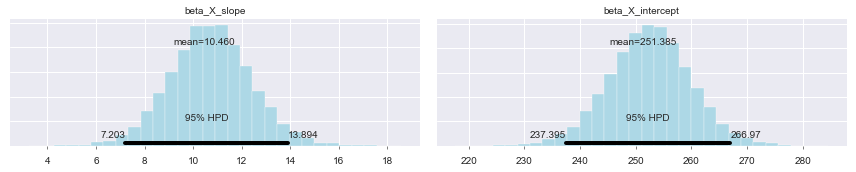

In [58]:
pm.plot_posterior(trace, varnames=['beta_X_slope', 'beta_X_intercept'], color='#add8e6')

In [60]:
pd.set_option('display.max_columns', 500)

trace_df = pm.trace_to_dataframe(trace)
trace_df.head()

,beta_X_slope,gamma_Z_offset_intercept__0,gamma_Z_offset_intercept__1,gamma_Z_offset_intercept__2,gamma_Z_offset_intercept__3,gamma_Z_offset_intercept__4,gamma_Z_offset_intercept__5,gamma_Z_offset_intercept__6,gamma_Z_offset_intercept__7,gamma_Z_offset_intercept__8,gamma_Z_offset_intercept__9,gamma_Z_offset_intercept__10,gamma_Z_offset_intercept__11,gamma_Z_offset_intercept__12,gamma_Z_offset_intercept__13,gamma_Z_offset_intercept__14,gamma_Z_offset_intercept__15,gamma_Z_offset_intercept__16,gamma_Z_offset_intercept__17,gamma_Z_offset_slope__0,gamma_Z_offset_slope__1,gamma_Z_offset_slope__2,gamma_Z_offset_slope__3,gamma_Z_offset_slope__4,gamma_Z_offset_slope__5,gamma_Z_offset_slope__6,gamma_Z_offset_slope__7,gamma_Z_offset_slope__8,gamma_Z_offset_slope__9,gamma_Z_offset_slope__10,gamma_Z_offset_slope__11,gamma_Z_offset_slope__12,gamma_Z_offset_slope__13,gamma_Z_offset_slope__14,gamma_Z_offset_slope__15,gamma_Z_offset_slope__16,gamma_Z_offset_slope__17,beta_X_intercept,beta_X__0,beta_X__1,sigma_Z_intercept,sigma_Z_slope,gamma_Z_intercept__0,gamma_Z_intercept__1,gamma_Z_intercept__2,gamma_Z_intercept__3,gamma_Z_intercept__4,gamma_Z_intercept__5,gamma_Z_intercept__6,gamma_Z_intercept__7,gamma_Z_intercept__8,gamma_Z_intercept__9,gamma_Z_intercept__10,gamma_Z_intercept__11,gamma_Z_intercept__12,gamma_Z_intercept__13,gamma_Z_intercept__14,gamma_Z_intercept__15,gamma_Z_intercept__16,gamma_Z_intercept__17,gamma_Z_slope__0,gamma_Z_slope__1,gamma_Z_slope__2,gamma_Z_slope__3,gamma_Z_slope__4,gamma_Z_slope__5,gamma_Z_slope__6,gamma_Z_slope__7,gamma_Z_slope__8,gamma_Z_slope__9,gamma_Z_slope__10,gamma_Z_slope__11,gamma_Z_slope__12,gamma_Z_slope__13,gamma_Z_slope__14,gamma_Z_slope__15,gamma_Z_slope__16,gamma_Z_slope__17,sigma
0,14.015833,671.913434,-1865.476377,-902.430575,1755.988224,1813.263012,362.246369,905.082918,-406.341307,323.604063,2207.992340,-927.573382,-1424.910736,379.018375,998.432986,488.039224,-897.418754,401.290729,918.266019,735.556930,-1741.456145,-1462.089380,-994.249861,-1039.542664,-127.409497,-226.055752,-66.304493,-1876.578782,819.489437,-506.036108,1249.512678,-573.178841,226.468472,-158.905994,-46.099081,-345.303416,-103.315750,243.055016,243.055016,14.015833,0.018459,0.007159,12.402559,-34.434021,-16.657575,32.413027,33.470237,6.686549,16.706534,-7.500478,5.973267,40.756375,-17.121676,-26.301811,6.996136,18.429642,9.008505,-16.565064,7.407252,16.949875,5.265932,-12.467273,-10.467257,-7.117943,-7.442199,-0.912138,-1.618358,-0.474681,-13.434631,5.866814,-3.622767,8.945397,-4.103450,1.621312,-1.137625,-0.330028,-2.472065,-0.739649,23.044848
1,13.432549,628.596321,-1084.424070,-1609.743462,720.951004,943.038654,85.354941,1365.348859,-21.261884,228.048401,1841.145165,-1086.549647,-701.318568,997.224351,797.816824,846.659798,-718.314387,556.481773,1080.572917,755.114960,-1703.336861,-1123.993069,-1052.925954,-737.767483,-346.661094,-812.801211,-310.863067,-2014.641337,545.417880,183.924466,505.113099,-1368.542488,218.187881,-737.485723,491.531032,-1059.901714,-695.038681,243.977663,243.977663,13.432549,0.029219,0.007569,18.367094,-31.686025,-47.035447,21.065625,27.554853,2.494005,39.894428,-0.621256,6.663396,53.796824,-31.748132,-20.491981,29.138117,23.311585,24.738738,-20.988586,16.259963,31.573497,5.715422,-12.892460,-8.507440,-7.969537,-5.584120,-2.623858,-6.152046,-2.352905,-15.248706,4.128237,1.392114,3.823172,-10.358421,1.651452,-5.581988,3.720371,-8.022336,-5.260708,23.321982
2,10.416355,-485.540881,-1285.849057,-787.590871,1267.152207,1254.404240,1107.389825,523.924763,-157.486589,392.636390,927.423527,-289.540154,-404.723356,-330.427671,1143.583386,-283.608174,-943.554471,-231.362757,124.871239,1248.420023,-637.941197,-586.399316,-746.155809,-709.571085,-73.265771,-29.396466,140.551745,-1313.100042,1395.537382,-220.273633,583.204580,-10.769179,303.528590,390.364077,288.829242,245.030403,384.600603,250.056999,250.056999,10.416355,0.028628,0.009587,-13.899845,-36.810707,-22.546796,36.275462,35.910519,31.701857,14.

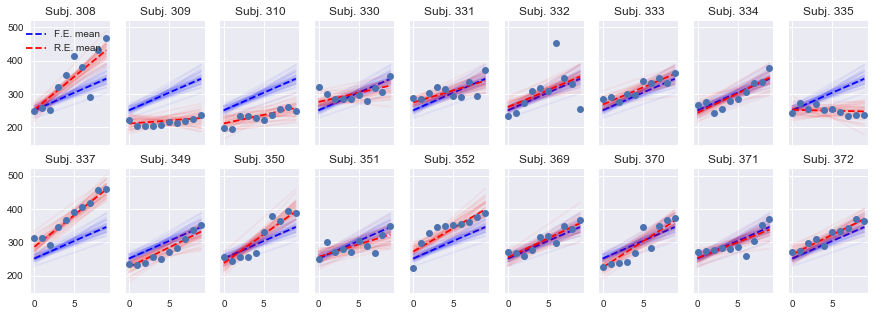

In [61]:
days = np.unique(sleep.Days)
subject_ids = np.unique(sleep.Subject)

fig, ax = plt.subplots(nrows=2, ncols=9, figsize=(15, 5), sharex=True, sharey=True)
ax = ax.ravel()
    
# Main effect  
for i, subject in enumerate(subject_ids):
    for b0, b1 in zip(trace_df['beta_X_intercept'][::500], 
                      trace_df['beta_X_slope'][::500]):
        ax[i].plot(days, b0 + days*b1, '-b', alpha=0.05)
        ax[i].set_title('Subj. {}'.format(subject))

        
for i, subject in enumerate(subject_ids):
    ax[i].plot(days, trace_df['beta_X_intercept'].mean() + days*trace_df['beta_X_slope'].mean(), '--b',
              label='F.E. mean')
    
# Random effect
for i, subject in enumerate(subject_ids):
    for b0, b1 in zip(trace_df['gamma_Z_intercept__{}'.format(i)][::500], 
                      trace_df['gamma_Z_slope__{}'.format(i)][::500]):
        ax[i].plot(days, trace_df['beta_X_intercept'].mean() + b0 + 
                   days * (trace_df['beta_X_slope'].mean() + b1), '-r', alpha=0.05)

for i, subject in enumerate(subject_ids):
    ax[i].plot(days,
               trace_df['beta_X_intercept'].mean() + trace_df['gamma_Z_intercept__{}'.format(i)].mean() + 
               days * (trace_df['beta_X_slope'].mean() + trace_df['gamma_Z_slope__{}'.format(i)].mean()), '--r', 
               label='R.E. mean')    
    

for i, subject in enumerate(subject_ids):
    ax[i].plot(days, sleep.Reaction[sleep.Subject==subject].values, 'o')
    

ax[0].legend()

## Khatri Rao product to construct Z

In [23]:
J = patsy.dmatrix('0 + Subject', data=sleep, return_type='dataframe')
J = np.asarray(J)
J.shape

(180, 18)

In [24]:
X.shape

(180, 2)

In [29]:
Z_kr = np.zeros((J.shape[0], X.shape[1]*J.shape[1]))
Z_kr.shape

(180, 36)

In [32]:
np.kron(J[0, :], X[0, :]).shape

(36,)

In [35]:
for ji in np.arange(0, J.shape[1]):
    for xi in np.arange(0, X.shape[1]):
        Z_kr[ji, :] = np.kron(J[ji, :], X[xi, :])

In [37]:
Z_kr.shape

(180, 36)

In [39]:
Z.shape

(180, 36)

In [40]:
Z_kr[:10, :10]

array([[1., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 1., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [44]:
Z[-10:-1, -10:-1]

array([[0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0.]])